# Import packages

In [ ]:
!pip install keras_self_attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras_self_attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18894 sha256=c074afd0324a5c37689eb1721a3226ad9eb7d0c2001e7379524a7ac57125845f
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras_self_attention


In [ ]:
# general pakage
from numpy import array
import numpy as np
import sys
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import random

# model
import tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import LSTM,GRU,Dropout,Masking,Bidirectional
from tensorflow.keras import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam
from keras_self_attention import SeqSelfAttention
from keras.callbacks import Callback

#link
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Prepare: One hot vector and split data

In [ ]:
#load data: use diagnose data
#if want to load procedure data, uncomment following code as seq_file
#seq_file="/content/drive/MyDrive/456/submit_code/data/procedures.seqs"
seq_file="/content/drive/MyDrive/456/submit_code/data/diagnose.seqs"
data = pickle.load(open(seq_file, 'rb'))

#data clean - no duplicated CSS for each admission
def deduplicate(data):
  cleaned_data = []
  for sublist1 in data:
      cleaned_sublist1 = []
      for sublist2 in sublist1:
          cleaned_sublist2 = list(set(sublist2))
          cleaned_sublist1.append(cleaned_sublist2)
      cleaned_data.append(cleaned_sublist1)
  return cleaned_data

data = deduplicate(data)

In [ ]:
#calculate the number of uniqe css code
unique_values = sorted(set(item for sublist in data for subsublist in sublist for item in subsublist))
num_unique_values = len(unique_values)
print(num_unique_values)

128


In [ ]:
# one hot encoding
def prepareHotVectors(train_tensor,numberOfInputCodes):
	nVisitsOfEachPatient_List = np.array([len(seq) for seq in train_tensor]) - 1
	numberOfPatients = len(train_tensor)
	maxNumberOfAdmissions = np.max(nVisitsOfEachPatient_List)

	x_hotvectors_tensorf = np.zeros((numberOfPatients, maxNumberOfAdmissions, numberOfInputCodes))#.astype(config.floatX)
	y_hotvectors_tensor = np.zeros((numberOfPatients, maxNumberOfAdmissions, numberOfInputCodes))#.astype(config.floatX)
	mask = np.zeros((numberOfPatients, maxNumberOfAdmissions))

	for idx, train_patient_matrix in enumerate(train_tensor):
		for i_th_visit, visit_line in enumerate(train_patient_matrix[:-1]): #ignores the last admission, which is not part of the training
			for code in visit_line:
				x_hotvectors_tensorf[idx, i_th_visit, code] = 1
		for i_th_visit, visit_line in enumerate(train_patient_matrix[1:]):  #label_matrix[1:] = all but the first admission slice, not used to evaluate (this is the answer)
			for code in visit_line:
				y_hotvectors_tensor[idx, i_th_visit, code] = 1
		mask[idx, :nVisitsOfEachPatient_List[idx]] = 1

	#nVisitsOfEachPatient_List = np.array(nVisitsOfEachPatient_List)=#config.floatX)
	x_hotvectors_tensorb = x_hotvectors_tensorf[::-1,::,::] #backward tensor for bi-directional processing
	return x_hotvectors_tensorf, x_hotvectors_tensorb, y_hotvectors_tensor, mask, nVisitsOfEachPatient_List

x_hotvectors_tensorf, x_hotvectors_tensorb, y_hotvectors_tensor, mask, nVisitsOfEachPatient_List = prepareHotVectors(data,numberOfInputCodes=num_unique_values)

In [ ]:
#split data as train and test
np.random.seed(2024)
sample_size = int(0.85 * len(x_hotvectors_tensorf))
size = len(x_hotvectors_tensorf)
train_indices = random.sample(list(range(size)), sample_size)


X_train = np.array([x_hotvectors_tensorf[i] for i in train_indices])
y_train = np.array([y_hotvectors_tensor[i] for i in train_indices])
X_test = np.array([x_hotvectors_tensorf[i] for i in range(size) if i not in train_indices])
y_test = np.array([y_hotvectors_tensor[i] for i in range(size) if i not in train_indices])

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4964, 28, 128)
(4964, 28, 128)
(877, 28, 128)
(877, 28, 128)


# Model

For model training, we experimented with different configurations of neurons and layers for each model. The results of these experiments are detailed in the Results section of the paper. In the following code, we present the best-performing model with the following settings: single layer neurons = 256.

## MLP

In [ ]:
# MLP model definition
model = Sequential()
# add dense layer
model.add(Dense(256,input_shape=(X_train.shape[1], X_train.shape[2]), activation ='tanh'))
# model.add(Dense(256), activation = 'tanh')
# model.add(Dense(256), activation = 'tanh')
# add dropout layer
model.add(Dropout(0.1))
# add output layer
model.add(TimeDistributed(Dense(X_train.shape[2], activation='softmax')))
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 28, 256)           33024     
                                                                 
 dropout_19 (Dropout)        (None, 28, 256)           0         
                                                                 
 time_distributed_19 (TimeD  (None, 28, 128)           32896     
 istributed)                                                     
                                                                 
Total params: 65920 (257.50 KB)
Trainable params: 65920 (257.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# training hyperparameters
n_epochs=10
history = model.fit(X_train, y_train, epochs=n_epochs, verbose=0, batch_size=32)

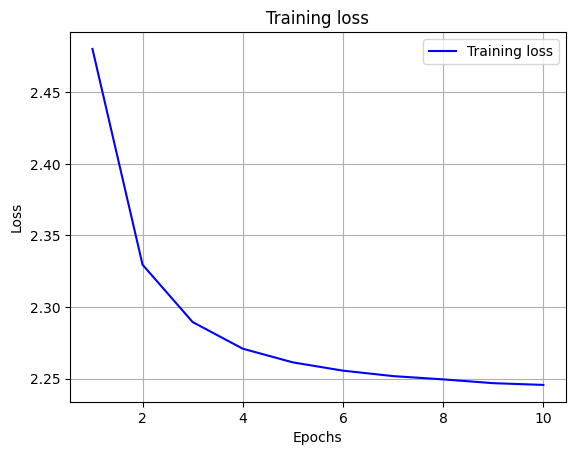

In [ ]:
import matplotlib.pyplot as plt
# Getting necessary data for plotting
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

# Plotting training loss
# "b" is for "solid blue line"
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.xscale(value='log')
#plt.yscale(value='log')
plt.grid()
plt.show()

In [ ]:
# predict using test data
predicted_probabilities = model.predict(X_test, verbose=0)
true_diagnoses=[]
# extract the ture dianosis label
for sublist in test_data:
    y_test_sublist = sublist[1:]
    true_diagnoses.append(y_test_sublist)

In [ ]:
# calculate top-k recall
k=[10,20,30]
def recall_at_k(true_diagnoses, predicted_probabilities, k):
    num_patients = len(true_diagnoses)
    correct_predictions = 0

    for i in range(num_patients):
      for j in range(len(true_diagnoses[i])):
        true_diagnosis_set = set(true_diagnoses[i][j])
        predicted_top_k = [code for _, code in sorted(zip(predicted_probabilities[i][j], range(len(predicted_probabilities[i][j]))), reverse=True)[:k]]
        correct_predictions += len(true_diagnosis_set.intersection(set(predicted_top_k)))

    total_true_diagnoses = sum(len(admission) for patient in true_diagnoses for admission in patient)
    return correct_predictions / total_true_diagnoses
# print top-10, top-20, top-30 recall
for i in k:
  recall_at_k_value = recall_at_k(true_diagnoses, predicted_probabilities, i)
  print("Recall@{}: {:.2f}".format(k, recall_at_k_value))

Recall@[10, 20, 30]: 0.36
Recall@[10, 20, 30]: 0.56
Recall@[10, 20, 30]: 0.67


## Feed Forward GRU

In [ ]:
# FF-GRU model definition
model = Sequential()
# add GRU layer
model.add(GRU(256,input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation = 'tanh'))
# add dropout layer
model.add(Dropout(0.1))
# add output layer
model.add(TimeDistributed(Dense(X_train.shape[2], activation='softmax')))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 28, 256)           296448    
                                                                 
 dropout_6 (Dropout)         (None, 28, 256)           0         
                                                                 
 time_distributed_6 (TimeDi  (None, 28, 128)           32896     
 stributed)                                                      
                                                                 
Total params: 329344 (1.26 MB)
Trainable params: 329344 (1.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# training hyperparameters
n_epochs=10
history = model.fit(X_train, y_train, epochs=n_epochs, verbose=0)

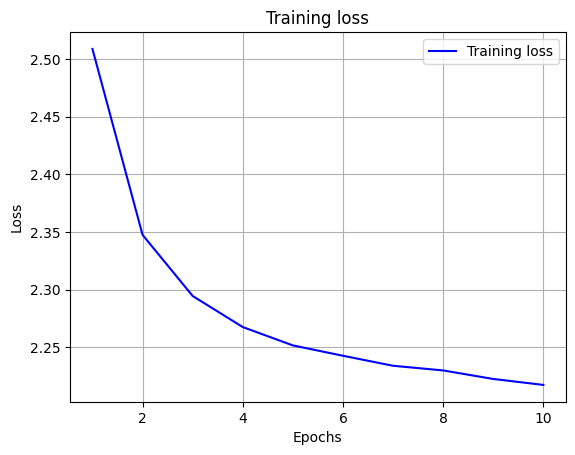

In [ ]:
# Getting necessary data for plotting
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

# Plotting training loss
# "b" is for "solid blue line"
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.xscale(value='log')
#plt.yscale(value='log')
plt.grid()
plt.show()

In [ ]:
# predict using test data
predicted_probabilities = model.predict(X_test, verbose=0)
true_diagnoses=[]
# extract the ture dianosis label
for sublist in test_data:
    y_test_sublist = sublist[1:]
    true_diagnoses.append(y_test_sublist)

In [ ]:
k=[10,20,30]
# print top-10, top-20, top-30 recall
for i in k:
  recall_at_k_value = recall_at_k(true_diagnoses, predicted_probabilities, i)
  print("Recall@{}: {:.2f}".format(k, recall_at_k_value))

Recall@[10, 20, 30]: 0.37
Recall@[10, 20, 30]: 0.56
Recall@[10, 20, 30]: 0.67


## Feed Forward LSTM

In [ ]:
# FF-LSTM model definition
model = Sequential()
# add GRU layer
model.add(LSTM(256,input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation = 'tanh'))
# add dropout layer
model.add(Dropout(0.1))
# add output layer
model.add(TimeDistributed(Dense(X_train.shape[2], activation='softmax')))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 28, 256)           394240    
                                                                 
 dropout_7 (Dropout)         (None, 28, 256)           0         
                                                                 
 time_distributed_7 (TimeDi  (None, 28, 128)           32896     
 stributed)                                                      
                                                                 
Total params: 427136 (1.63 MB)
Trainable params: 427136 (1.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# training hyperparameters
n_epochs=10
history = model.fit(X_train, y_train, epochs=n_epochs, verbose=0)

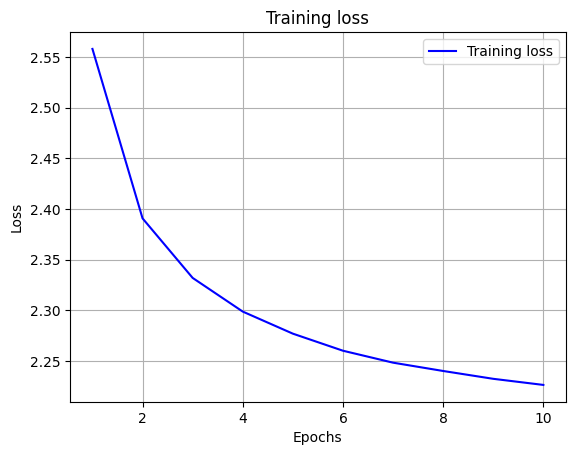

In [ ]:
# Getting necessary data for plotting
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

# Plotting training loss
# "b" is for "solid blue line"
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.xscale(value='log')
#plt.yscale(value='log')
plt.grid()
plt.show()

In [ ]:
# predict using test data
predicted_probabilities = model.predict(X_test, verbose=0)
true_diagnoses=[]
# extract the ture dianosis label
for sublist in test_data:
    y_test_sublist = sublist[1:]
    true_diagnoses.append(y_test_sublist)

In [ ]:
k=[10,20,30]
# print top-10, top-20, top-30 recall
for i in k:
  recall_at_k_value = recall_at_k(true_diagnoses, predicted_probabilities, i)
  print("Recall@{}: {:.2f}".format(k, recall_at_k_value))

Recall@[10, 20, 30]: 0.36
Recall@[10, 20, 30]: 0.54
Recall@[10, 20, 30]: 0.65


## Bidirectional GRU

In [ ]:
# Bi-GRU model definition
model = Sequential()
# add bidirectional GRU layer
model.add(Bidirectional(GRU(256,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True, activation = 'tanh')))
#model.add(Bidirectional(GRU(256,return_sequences=True, activation = 'tanh')))
#model.add(Bidirectional(GRU(256,return_sequences=True, activation = 'tanh')))
# add dropout layer
model.add(Dropout(0.1))
# add output layer
model.add(TimeDistributed(Dense(X_train.shape[2], activation='softmax')))
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 28, 512)           592896    
 onal)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 28, 512)           0         
                                                                 
 time_distributed_10 (TimeD  (None, 28, 128)           65664     
 istributed)                                                     
                                                                 
Total params: 658560 (2.51 MB)
Trainable params: 658560 (2.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# training hyperparameters
n_epochs=10
history = model.fit(X_train, y_train, epochs=n_epochs, verbose=0)

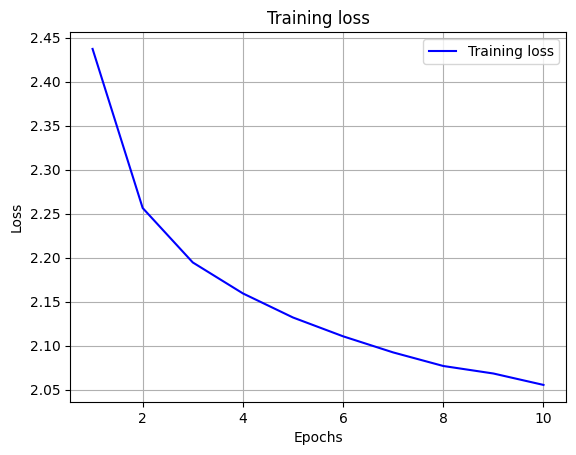

In [ ]:
# Getting necessary data for plotting
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

# Plotting training loss
# "b" is for "solid blue line"
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.xscale(value='log')
#plt.yscale(value='log')
plt.grid()
plt.show()

In [ ]:
# predict using test data
predicted_probabilities = model.predict(X_test, verbose=0)
true_diagnoses=[]
# extract the ture dianosis label
for sublist in test_data:
    y_test_sublist = sublist[1:]
    true_diagnoses.append(y_test_sublist)

In [ ]:
k=[10,20,30]
# print top-10, top-20, top-30 recall
for i in k:
  recall_at_k_value = recall_at_k(true_diagnoses, predicted_probabilities, i)
  print("Recall@{}: {:.2f}".format(k, recall_at_k_value))

Recall@[10, 20, 30]: 0.49
Recall@[10, 20, 30]: 0.67
Recall@[10, 20, 30]: 0.77


## Bidirectional LSTM

In [ ]:
# Bi-GRU model definition
model = Sequential()
# add bidirectional GRU layer
model.add(Bidirectional(LSTM(256,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True, activation = 'tanh')))
# model.add(Bidirectional(LSTM(256,return_sequences=True, activation = 'tanh')))
# model.add(Bidirectional(LSTM(256,return_sequences=True, activation = 'tanh')))
# add dropout layer
model.add(Dropout(0.1))
# add output layer
model.add(TimeDistributed(Dense(X_train.shape[2], activation='softmax')))
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirecti  (None, 28, 512)           788480    
 onal)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 28, 512)           0         
                                                                 
 time_distributed_12 (TimeD  (None, 28, 128)           65664     
 istributed)                                                     
                                                                 
Total params: 854144 (3.26 MB)
Trainable params: 854144 (3.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# training hyperparameters
n_epochs=10
history = model.fit(X_train, y_train, epochs=n_epochs, verbose=0)

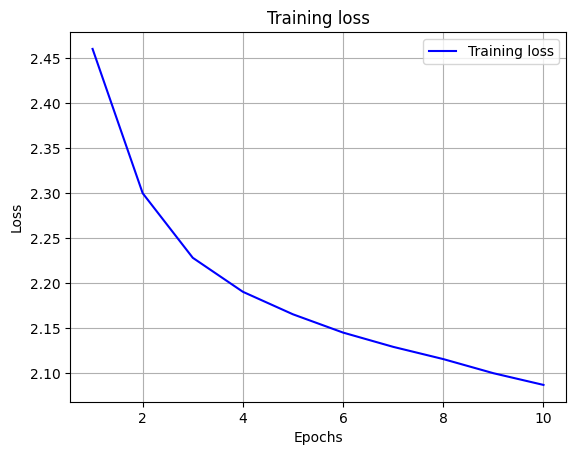

In [ ]:
# Getting necessary data for plotting
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

# Plotting training loss
# "b" is for "solid blue line"
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.xscale(value='log')
#plt.yscale(value='log')
plt.grid()
plt.show()

In [ ]:
# predict using test data
predicted_probabilities = model.predict(X_test, verbose=0)
true_diagnoses=[]
# extract the ture dianosis label
for sublist in test_data:
    y_test_sublist = sublist[1:]
    true_diagnoses.append(y_test_sublist)

In [ ]:
k=[10,20,30]
# print top-10, top-20, top-30 recall
for i in k:
  recall_at_k_value = recall_at_k(true_diagnoses, predicted_probabilities, i)
  print("Recall@{}: {:.2f}".format(k, recall_at_k_value))

Recall@[10, 20, 30]: 0.47
Recall@[10, 20, 30]: 0.66
Recall@[10, 20, 30]: 0.77


## Bidirectional + LReLU + Self Attention

In [ ]:
# Bi-GRU + LReLU + self attention model definition
model = Sequential()
# add bidirectional GRU layer
model.add(Bidirectional(GRU(256,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True, activation='LeakyReLU')))
# add dropout layer
model.add(Dropout(0.1))
# add self attention layer
model.add(SeqSelfAttention())
## Add output layer
model.add(TimeDistributed(Dense(X_train.shape[2], activation='softmax')))
#model.summary()

In [ ]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# training hyperparameters
n_epochs=10
history = model.fit(X_train, y_train, epochs=n_epochs, verbose=0)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


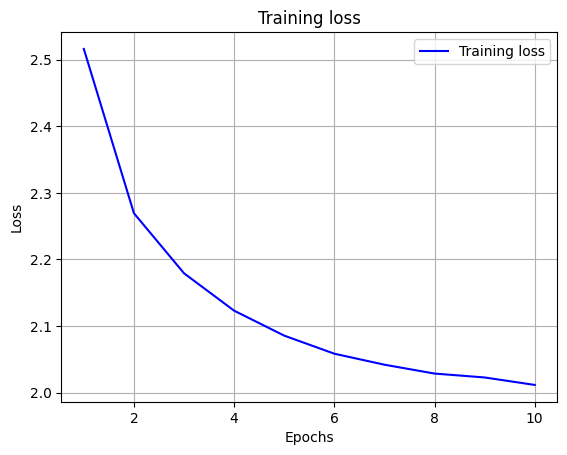

In [ ]:
# Getting necessary data for plotting
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

# Plotting training loss
# "b" is for "solid blue line"
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.xscale(value='log')
#plt.yscale(value='log')
plt.grid()
plt.show()

In [ ]:
# predict using test data
predicted_probabilities = model.predict(X_test, verbose=0)
true_diagnoses=[]
# extract the ture dianosis label
for sublist in test_data:
    y_test_sublist = sublist[1:]
    true_diagnoses.append(y_test_sublist)

In [ ]:
k=[10,20,30]
# print top-10, top-20, top-30 recall
for i in k:
  recall_at_k_value = recall_at_k(true_diagnoses, predicted_probabilities, i)
  print("Recall@{}: {:.2f}".format(k, recall_at_k_value))

Recall@[10, 20, 30]: 0.55
Recall@[10, 20, 30]: 0.73
Recall@[10, 20, 30]: 0.82


## Top-30 recall plot of BI-GRU with self-attention layer and BI-GRU without self-attention layer

In [ ]:
# MODEL DEFINITION
model1 = Sequential()
## Add BI-GRU layer with LeakyReLU
model1.add(Bidirectional(GRU(256,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True, activation='LeakyReLU')))
# add dropout layer
model1.add(Dropout(0.1))
## Add output layer
model1.add(TimeDistributed(Dense(X_train.shape[2], activation='softmax')))

model1.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
class RecallAtKCallback(Callback):
    def __init__(self, X_test, true_diagnoses, k):
        super(RecallAtKCallback, self).__init__()
        self.X_test = X_test
        self.true_diagnoses = true_diagnoses
        self.k = k
        self.recall_values = []

    def on_epoch_end(self, epoch, logs={}):
        predicted_probabilities = self.model.predict(self.X_test, verbose=0)
        recall_at_k_value = recall_at_k(self.true_diagnoses, predicted_probabilities, self.k)
        self.recall_values.append(recall_at_k_value)
        logs['val_recall_at_' + str(self.k)] = recall_at_k_value

# Create callbacks for each k value
recall_callbacks = [RecallAtKCallback(X_test, true_diagnoses, k) for k in [10, 20, 30]]

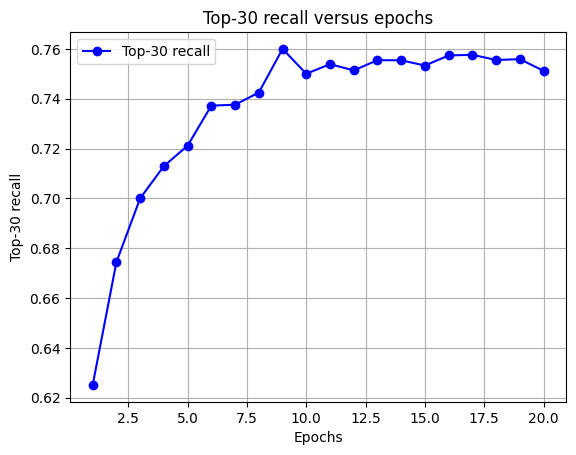

In [ ]:
# Getting necessary data for plotting
history1 = model1.fit(X_train, y_train, epochs=20, verbose=0, batch_size=32, validation_data=(X_test, y_test), callbacks=recall_callbacks)
recall_at_30_1 = history1.history['val_recall_at_30']
epochs = range(1, len(recall_at_30_1) + 1)

# Plotting training loss
plt.plot(epochs, recall_at_30_1, 'b', label='Top-30 recall', marker ='o')
plt.title('Top-30 recall versus epochs')
plt.xlabel('Epochs')
plt.ylabel('Top-30 recall')
plt.legend()
plt.grid()
plt.show()


In [ ]:
model2 = Sequential()
## Add BI-GRU layer with LeakyReLU
model2.add(Bidirectional(GRU(256,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True, activation='LeakyReLU')))
# add dropout layer
model2.add(Dropout(0.1))
# add self attention layer
model2.add(SeqSelfAttention())
## Add output layer
model2.add(TimeDistributed(Dense(X_train.shape[2], activation='softmax')))

model2.compile(loss='categorical_crossentropy', optimizer='adam')

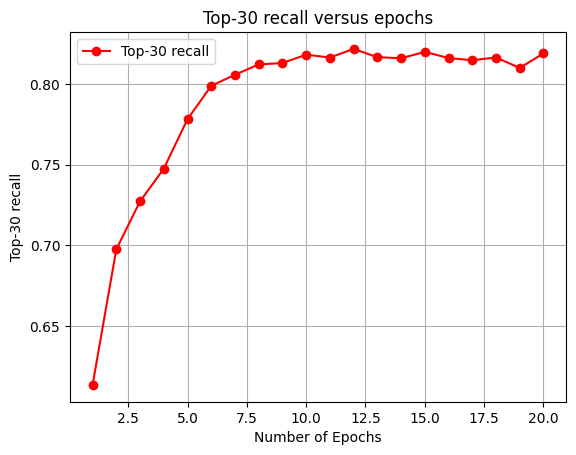

In [ ]:
# Getting necessary data for plotting
history2 = model2.fit(X_train, y_train, epochs=20, verbose=0, batch_size=32, validation_data=(X_test, y_test), callbacks=recall_callbacks)
recall_at_30_2 = history2.history['val_recall_at_30']
epochs = range(1, len(recall_at_30_1) + 1)

# Plotting training loss
plt.plot(epochs, recall_at_30_2, 'r', label='Top-30 recall', marker='o')
plt.title('Top-30 recall versus epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Top-30 recall')
plt.legend()
plt.grid()
plt.show()


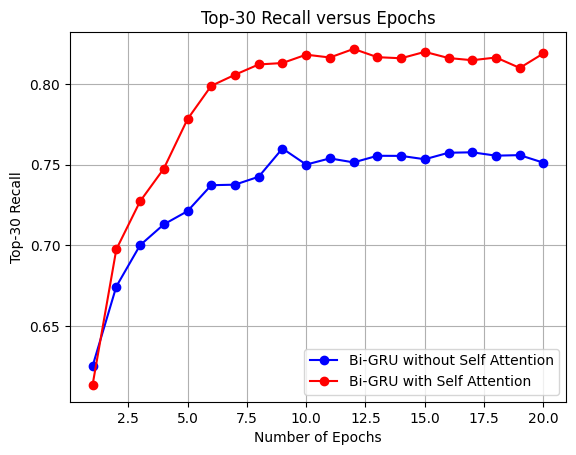

In [ ]:
# Plotting the graph

plt.plot(epochs, recall_at_30_1, 'b-o', label='Bi-GRU without Self Attention')  # 'b-o' specifies blue color with circle markers
plt.plot(epochs, recall_at_30_2, 'r-o', label='Bi-GRU with Self Attention')  # 'r-o' specifies red color with circle markers
plt.title('Top-30 Recall versus Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Top-30 Recall')
plt.legend()
plt.grid()
plt.show()
